In [1]:
import os
from dotenv import load_dotenv, find_dotenv 

_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

In [2]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

#### **Defining Agent**

In [25]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str
  budget: float
  expenses : List[dict]

In [26]:
from langchain_openai import ChatOpenAI 
llm = ChatOpenAI()
print(llm.invoke("Write 5 line Poem on Deep learning").content)

In the depths of data, deep learning lies,
A web of connections, a vast enterprise.
Neural networks search, patterns to find,
Unraveling mysteries of the human mind.
In the digital realm, intelligence thrives.


In [27]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a detailed trip itinerary for {city} based on the user's interests: {interests}. The user has a budget of ${budget:.2f}. Provide a brief description of the trip with estimation cost and days of trip user have defined, followed by a bulleted itinerary. Make sure to stay within the budget and suggest relevant activities."),
    ("human", "Create an itinerary for my trip.")
])

#### **Defining Agent Functions**

In [28]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the Place you want to visit for your trip: ")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

In [29]:
def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter your interested city for the trip to: {state['city']}")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

In [30]:
def input_budget(state: PlannerState) -> PlannerState:
    print("Please enter your budget for the trip (in USD): ")
    user_message = input("Your Input: ")
    budget = float(user_message)
    updated_state = {
        **state, 
        "budget": budget, 
        "messages": state["messages"] + [HumanMessage(content=f"My budget is ${budget}")],
    }
    return updated_state

In [31]:
def track_expenses(state: PlannerState) -> PlannerState:
    print(f"Tracking expenses for the trip to {state['city']}. Budget: ${state['budget']:.2f}")
    print("Enter your expenses in the format: item, cost (e.g., Hotel, 500): ")

    while True:
        user_message = input("Expense (or type 'done' to finish): ")
        if user_message.lower() == "done":
            break
        try:
            item, cost = user_message.split(",")
            cost = float(cost.strip())
            state["expenses"].append({"item": item.strip(), "cost": cost})
            print(f"Added expense: {item.strip()} - ${cost:.2f}")
        except ValueError:
            print("Invalid input. Please enter in the correct format.")

    total_expenses = sum(exp["cost"] for exp in state["expenses"])
    remaining_budget = state["budget"] - total_expenses
    print(f"\nTotal Expenses: ${total_expenses:.2f}")
    print(f"Remaining Budget: ${remaining_budget:.2f}")

    return {
        **state,
        "messages": state["messages"] + [HumanMessage(content=f"Tracked expenses. Total: ${total_expenses:.2f}, Remaining: ${remaining_budget:.2f}")],
    }

In [32]:
def create_itinerary(state: PlannerState) -> PlannerState:
    # Check if budget is present in the state before processing
    if 'budget' not in state:
        print("Error: 'budget' not found in the state.")
        return state
    
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=','.join(state['interests']), budget=state['budget']))
    print("\nFinal Itinerary: ")
    print(response.content)
    
    updated_state = {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }
    # print(f"State after create_itinerary: {updated_state}")  # Debug print
    return updated_state

#### **Create and compile the Graph**

In [33]:
workflow = StateGraph(PlannerState)
workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("input_budget", input_budget)
workflow.add_node("create_itinerary", create_itinerary)
workflow.add_node("track_expenses", track_expenses)

workflow.set_entry_point("input_city")
workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "input_budget")  # Ensure this edge is correct
workflow.add_edge("input_budget", "create_itinerary")
workflow.add_edge("create_itinerary", "track_expenses")
workflow.add_edge("track_expenses", END)

app = workflow.compile()

##### **Display Graph Structure**

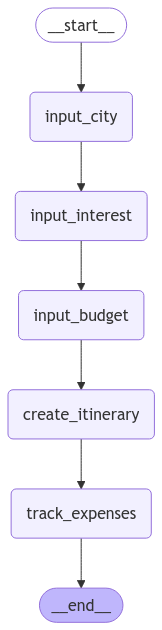

In [34]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

#### **Define the function that runs the graph**

In [35]:
def travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
        "budget": 0.0,
        "expenses": [],
    }
    
    # Process the workflow
    for output in app.stream(state):
        pass

In [40]:
user_request = "I want to plan trip to the given place"
travel_planner(user_request)

Initial Request: I want to plan trip to the given place

Please enter the Place you want to visit for your trip: 
Please enter your interested city for the trip to: Italy
Please enter your budget for the trip (in USD): 
Creating an itinerary for Italy based on interests: Venice

Final Itinerary: 
Absolutely! Here's a detailed trip itinerary for your visit to Venice, Italy within your budget of $2000.00 for a 4-day trip:

---

**Trip Description:**
Explore the enchanting city of Venice, known for its picturesque canals, historic architecture, and rich cultural heritage. Immerse yourself in the Venetian way of life by wandering through narrow streets, visiting iconic landmarks, enjoying delicious Italian cuisine, and taking a gondola ride through the city's waterways.

**Estimated Cost:** $1900.00  
**Duration:** 4 days

---

**Day 1: Arrival in Venice**
- Arrival in Venice
- Check into a budget-friendly hotel near the city center
- Stroll through St. Mark's Square and visit St. Mark's B

In [49]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq



interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Please enter the Place you want to visit for your trip: "),
        gr.Textbox(label="Please enter your interested city for the trip to: "),
        # gr.Textbox(label="Please enter your budget for the trip (in USD): ")
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()


* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


Created dataset file at: .gradio\flagged\dataset3.csv
